In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34151,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://10.6.121.1:39107,Total threads: 4
Dashboard: /proxy/37205/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:36197,


In [4]:
db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_stress_Pacific.db'
session = cc.database.create_session(db)

#expt = ['1deg_jra55_ryf_param_KPP', '1deg_jra55_ryf_stress_SH']
expt = '1deg_jra55_ryf_stress_Pacific'
#name = ['Control', 'Winds in SH']

db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_stress_SH.db'
session_SH = cc.database.create_session(db)

db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_stress_Pacific.db'
session_Pacific = cc.database.create_session(db)

expt = ['1deg_jra55_ryf_param_KPP', '1deg_jra55_ryf_stress_SH', '1deg_jra55_ryf_stress_Pacific']
session = [session_SH, session_SH, session_Pacific]
name = ['Control', 'Stress_SH', 'Nostress_Pacific']

In [5]:
start_time = '1990-01-01'
end_time = '1999-12-31'

In [ ]:
fig, axes = plt.subplots(ncols = 3, figsize = (20, 12))

dxt = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'dxt', n = -1).rename({'nj':'yt_ocean','ni':'xt_ocean'})
dyt = cc.querying.getvar(expt = expt[0], session = session[0], variable = 'dyt', n = -1).rename({'nj':'yt_ocean','ni':'xt_ocean'})

for i, j in enumerate(session):
    tau_x = cc.querying.getvar(expt = expt[i], session = j, variable = 'tau_x', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    tau_y = cc.querying.getvar(expt = expt[i], session = j, variable = 'tau_y', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    T = cc.querying.getvar(expt = expt, session = session, variable = 'temp', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    
    folder = '/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output000/ocean/'
    grid = xr.open_mfdataset(folder + 'ocean_grid.nc', combine = 'by_coords')

    ds = xr.merge([tau_x, tau_y, T, dxt, dyt])
    ds.coords['xt_ocean'].attrs.update(axis='X')
    ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
    ds.coords['yt_ocean'].attrs.update(axis='Y')
    ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

    grid = xgcm.Grid(ds, periodic=['X'])
    
    ζ_xgcm = grid.interp(grid.diff(ds.tau_y, 'X'), 'Y', boundary='extend')/ds.dxt - grid.interp(grid.diff(ds.tau_x, 'Y', boundary='extend'), 'X')/ds.dyt
    ζ_xgcm = ζ_xgcm.rename('Relative Vorticity')
    ζ_xgcm.attrs['long_name'] = 'Relative Vorticity, ∂v/∂x-∂u/∂y'
    ζ_xgcm.attrs['units'] = 's-1'
    ζ_xgcm = ζ_xgcm.drop(['TLON', 'TLAT', 'ULON', 'ULAT'])
    
    ζ_xgcm.plot(vmin = -1e-6, vmax = 1e-6, cmap = 'RdBu_r')

In [9]:
R = 6378 * 1e3
beta = (2*7.2921*1e-5 *np.cos(np.deg2rad(T.yt_ocean)))/(R)

In [10]:
mer_transport = (ζ_xgcm/beta).mean('time')

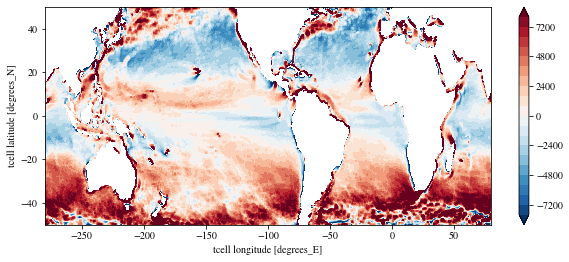

In [17]:
plt.figure(figsize = (10, 4))
mer_transport.sel(yt_ocean = slice(-50, 50)).plot.contourf(levels = np.linspace(-8e3, 8e3, 21))